## Section 0: Justin Chan

## Section 1: Predict Climate Model Simulation Outcome based on the Model Input Parameters

## Section 2: Project Definition

### Goals

The goal of this project is to determine if the various variables used in a climate model simulation can be used to predict whether a particular simulation will crash.

### Dataset

The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Climate+Model+Simulation+Crashes

It is based out of climate model research by the Lawrence Livermore National Laboratory, Livermore 
and Department of Astronomy, Univesity of California, Berkeley. 
18 parameters from the CCSM4 parallel ocean model are provided.

A reference paper from that research, "Failure analysis of parameter-induced simulation crashes in climate models" 
can be found here: https://pdfs.semanticscholar.org/e29a/a9962e398308f5c1aee889912c130552ec05.pdf
    
    
### Tasks

List the tasks you will perform. Please edit the example below accordingly to your actual tasks.

Example:
 
1. Process the dataset to convert strings into labels.
2. Shuffle and split into train and test sets
3. Train a classification model, using algorithm A, B, C...
4. Compute the metrics for the algorithm.
5. Perform analysis for possible improvements.

## Section 3: Data Engineering

We perform the following
* Import libraries and data
* Data Exploration and checks (ie. verify outcomes, scatterplots) 
* Imbalance / Data Sampling

In [202]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline

import pickle

%matplotlib inline

In [203]:
#load data
df = pd.read_csv("./pop_failures.dat", sep="\s+")
df.head()

Study  Run  vconst_corr  vconst_2  vconst_3  vconst_4  vconst_5  vconst_7  \
0      1    1     0.859036  0.927825  0.252866  0.298838  0.170521  0.735936   
1      1    2     0.606041  0.457728  0.359448  0.306957  0.843331  0.934851   
2      1    3     0.997600  0.373238  0.517399  0.504993  0.618903  0.605571   
3      1    4     0.783408  0.104055  0.197533  0.421837  0.742056  0.490828   
4      1    5     0.406250  0.513199  0.061812  0.635837  0.844798  0.441502   

    ah_corr  ah_bolus  ...  efficiency_factor  tidal_mix_max  \
0  0.428325  0.567947  ...           0.245675       0.104226   
1  0.444572  0.828015  ...           0.616870       0.975786   
2  0.746225  0.195928  ...           0.679355       0.803413   
3  0.005525  0.392123  ...           0.471463       0.597879   
4  0.191926  0.487546  ...           0.551543       0.743877   

   vertical_decay_scale  convect_corr  bckgrnd_vdc1  bckgrnd_vdc_ban  \
0              0.869091      0.997518      0.448620         0.307522   
1              0.914344      0.845247      0.864152         0.346713   
2              0.643995      0.718441      0.924775         0.315371   
3              0.761659      0.362751      0.912819         0.977971   
4              0.312349      0.650223      0.522261         0.043545   

   bckgrnd_vdc_eq  bckgrnd_vdc_psim   Prandtl  outcome  
0        0.858310          0.796997  0.869893        0  
1        0.356573          0.438447  0.512256        1  
2        0.250642          0.285636  0.365858        1  
3        0.845921          0.699431  0.475987        1  
4        0.376660          0.280098  0.132283        1  

[5 rows x 21 columns]

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 21 columns):
Study                   540 non-null int64
Run                     540 non-null int64
vconst_corr             540 non-null float64
vconst_2                540 non-null float64
vconst_3                540 non-null float64
vconst_4                540 non-null float64
vconst_5                540 non-null float64
vconst_7                540 non-null float64
ah_corr                 540 non-null float64
ah_bolus                540 non-null float64
slm_corr                540 non-null float64
efficiency_factor       540 non-null float64
tidal_mix_max           540 non-null float64
vertical_decay_scale    540 non-null float64
convect_corr            540 non-null float64
bckgrnd_vdc1            540 non-null float64
bckgrnd_vdc_ban         540 non-null float64
bckgrnd_vdc_eq          540 non-null float64
bckgrnd_vdc_psim        540 non-null float64
Prandtl                 540 non-null float64

In [205]:
df[df.isna().values]

Empty DataFrame
Columns: [Study, Run, vconst_corr, vconst_2, vconst_3, vconst_4, vconst_5, vconst_7, ah_corr, ah_bolus, slm_corr, efficiency_factor, tidal_mix_max, vertical_decay_scale, convect_corr, bckgrnd_vdc1, bckgrnd_vdc_ban, bckgrnd_vdc_eq, bckgrnd_vdc_psim, Prandtl, outcome]
Index: []

[0 rows x 21 columns]

### Data Observations 1
* We observe that there are 21 columns. There are 3 studies (ie. identified by "Study" column), each with 180 runs 
(ie. "Run" column). This gives 540 simulations (ie. 3 * 180). Each row represents a simulation with an 'outcome' column 
indicating whether the simulation crashed (ie. '0' is failure, '1' is success). NOTE: WE REVERSE THE OUTCOME LABELLING BELOW!!

* There are no empty cells. 

* The remaining 18 columns are the model input parameters. All are numeric.

* From the reference paper:
  * Out of the 540 total simulations, 46 were failures. We have an imbalanced data set.
  * 18 parameters used in each simulation were derived by Latin hypercube method to provide stratified, space-filled sampling.

In [206]:
# verify 46 failures out of 540 simmulations
df['outcome'].value_counts()

1    494
0     46
Name: outcome, dtype: int64

In [207]:
#reverse 0 and 1 for outcome
df['outcome'] = df['outcome'].map(lambda x: 1 if x==0 else 0)

In [208]:
df['outcome'].value_counts()

0    494
1     46
Name: outcome, dtype: int64

In [209]:
#base line probability of failure, success
print("Failure:",  46/540)
print("Success:",  494/540)

Failure: 0.08518518518518518
Success: 0.9148148148148149


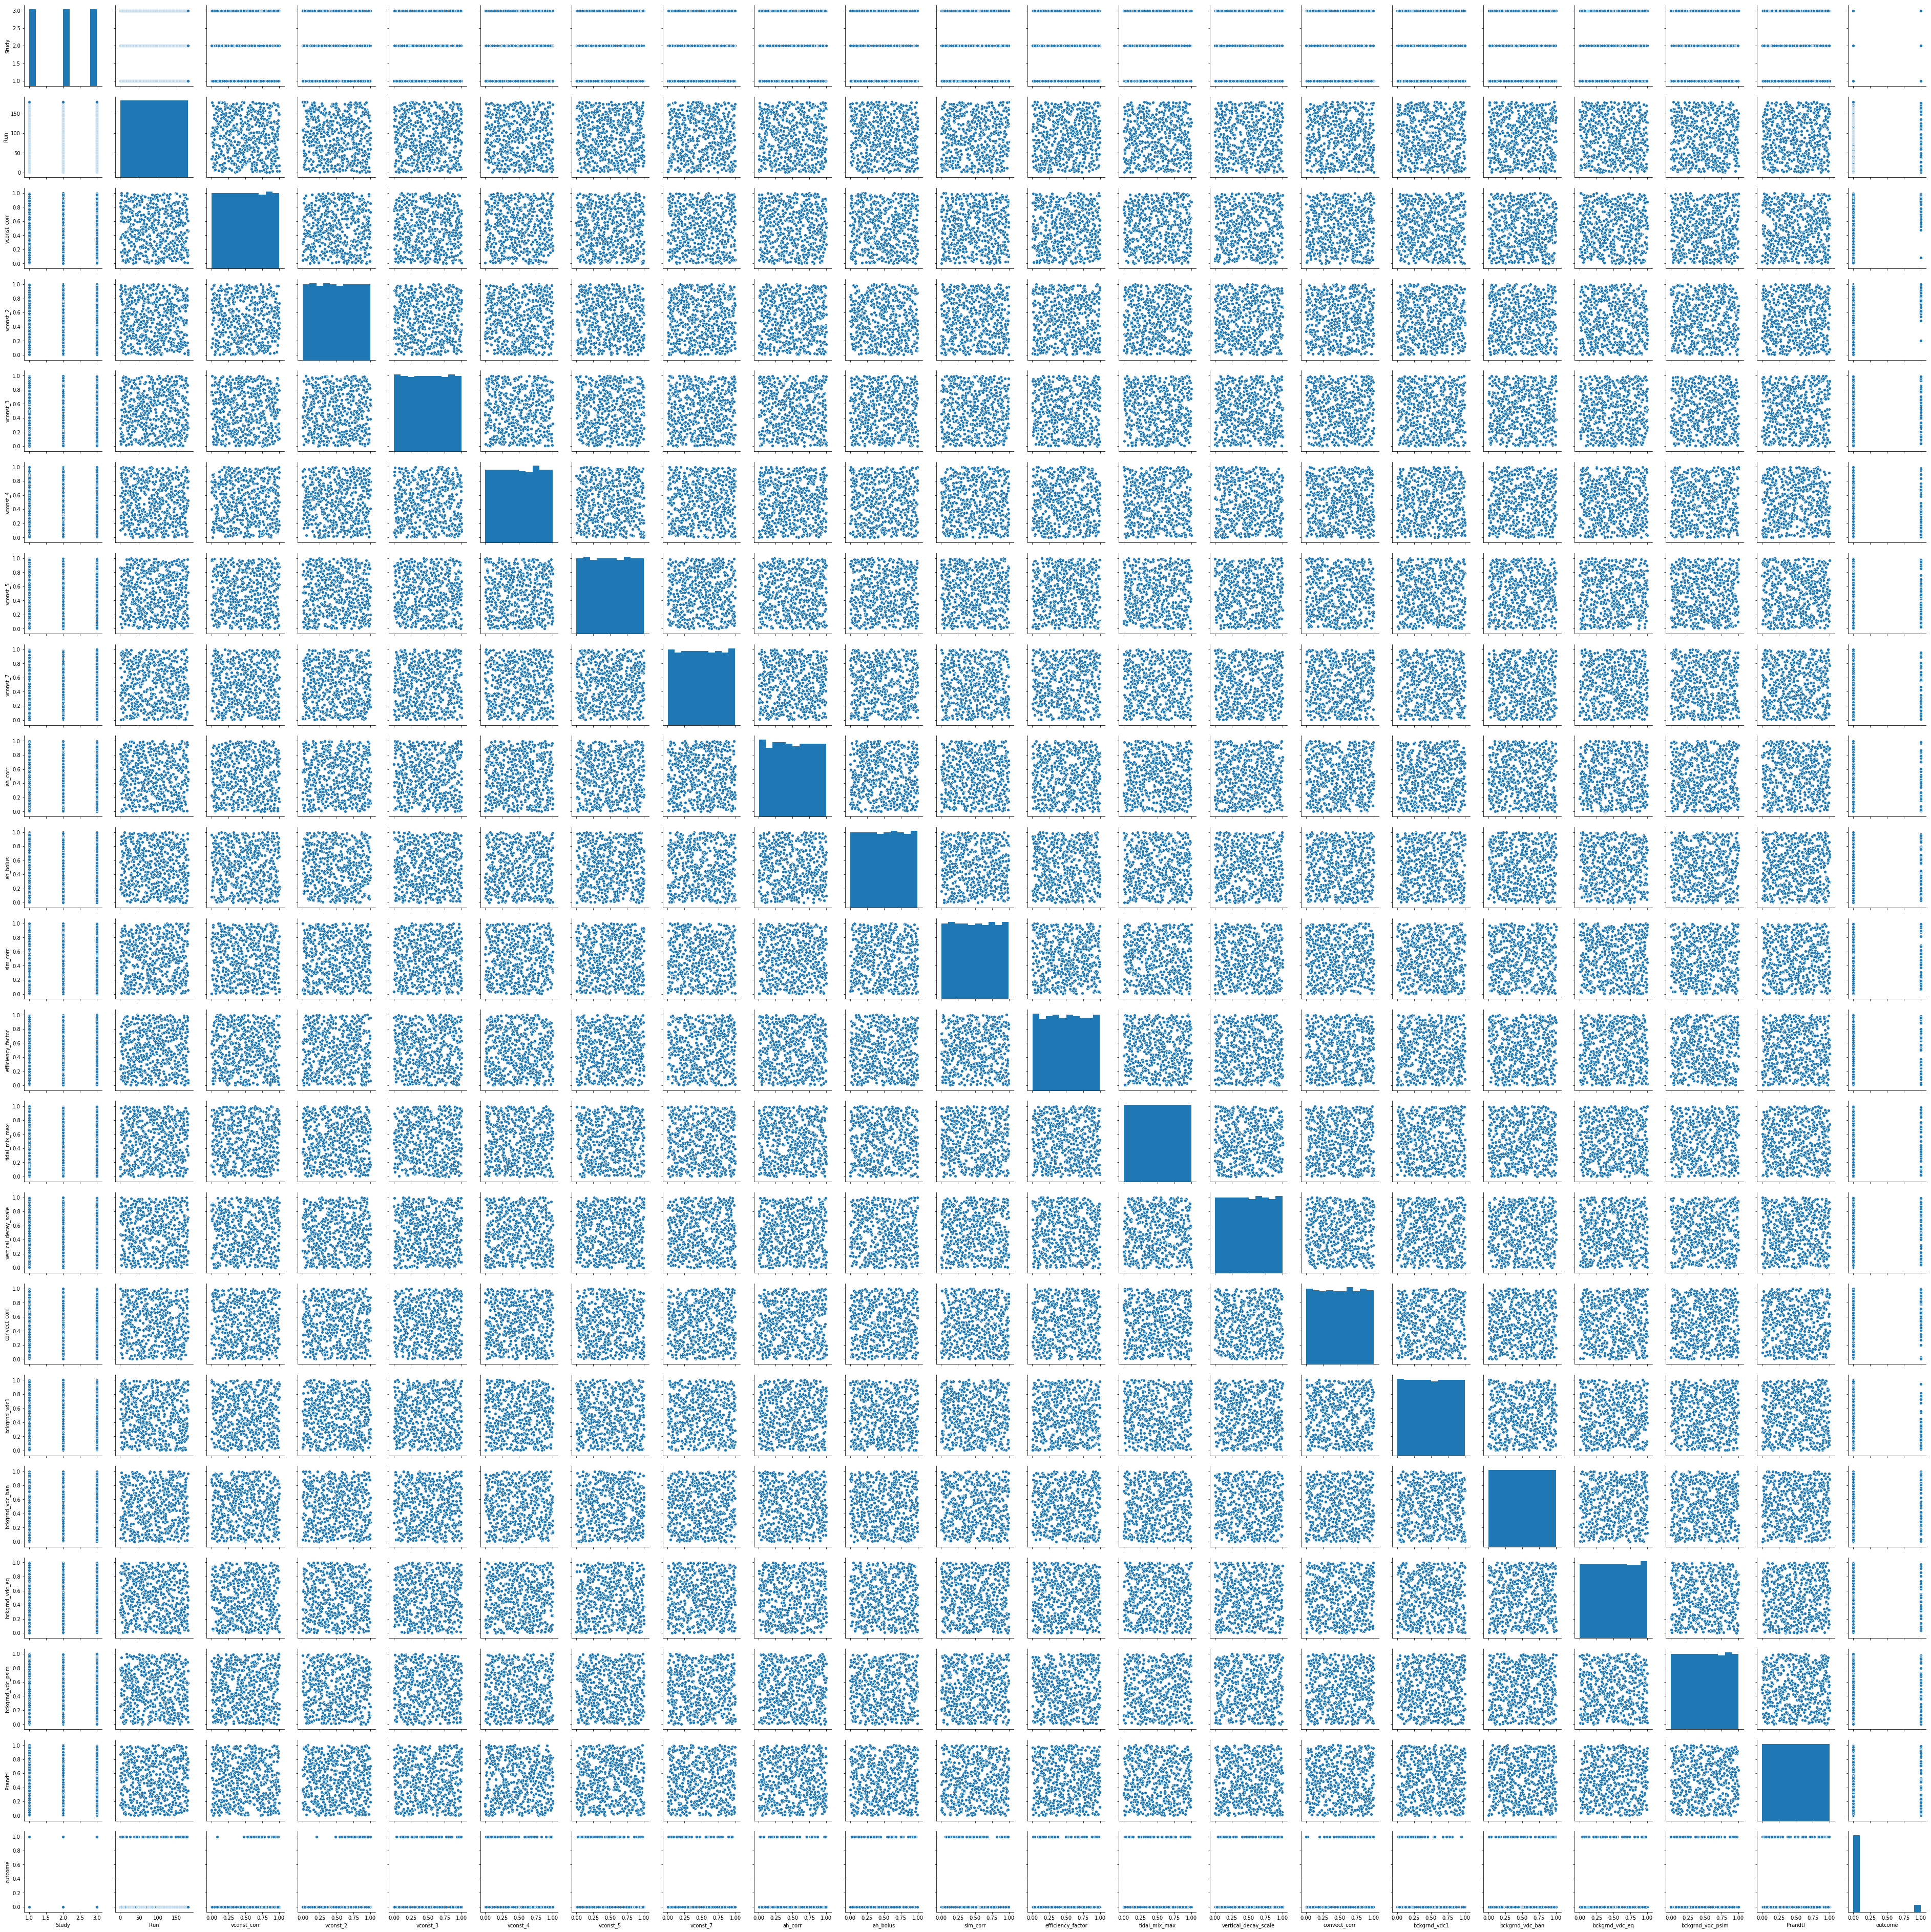

In [210]:
#pairplot
sns.pairplot(df)

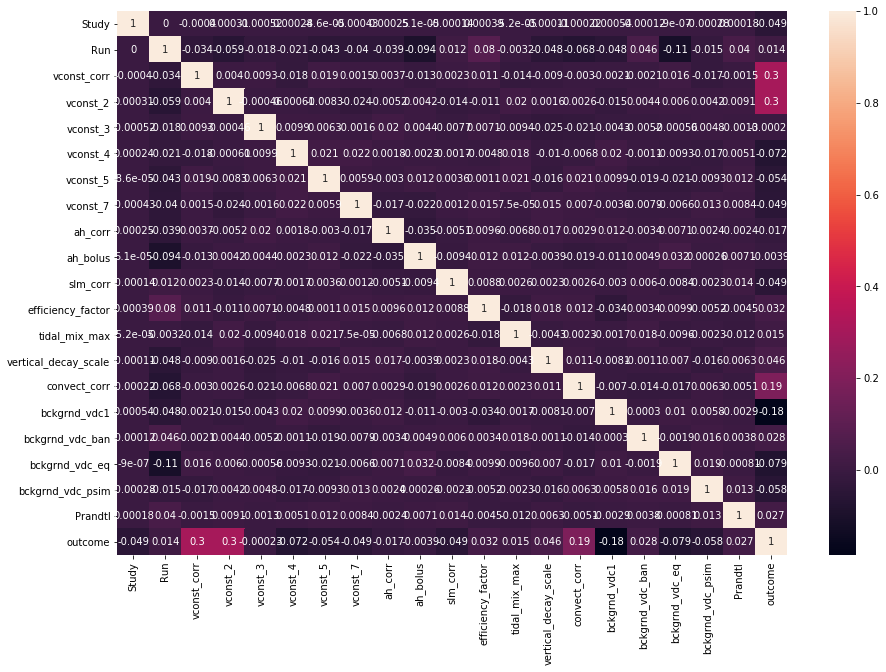

In [211]:
# scatterplot to show low correlation
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, ax=ax)

### Data Observations 2

* We verified that 46 out of 540 are failures (ie. outcome is '0').

* From the pairplot and correlation scatterplot, we observed that the 18 parameters are uncorrelated 
(largely due to Latin Hypercube sampling).

* There are weak correlations between outcome and the parameters vconst_corr, vconst_2, convect_corr and bckgrnd_vdc1.

In [212]:
#split data sets into train and test
df_train = df[df['Study']<=2]
df_test= df[df['Study']==3]
print(df_train.shape, df_test.shape)

(360, 21) (180, 21)


In [213]:
df.columns

Index(['Study', 'Run', 'vconst_corr', 'vconst_2', 'vconst_3', 'vconst_4',
       'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus', 'slm_corr',
       'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq',
       'bckgrnd_vdc_psim', 'Prandtl', 'outcome'],
      dtype='object')

In [214]:
features = ['vconst_corr', 'vconst_2', 'vconst_3', 'vconst_4',
       'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus', 'slm_corr',
       'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq',
       'bckgrnd_vdc_psim', 'Prandtl']
target = ['outcome']

X_train=df_train.loc[:, features]
y_train=df_train.loc[:, target]

(360, 2)
(360, 1)
<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


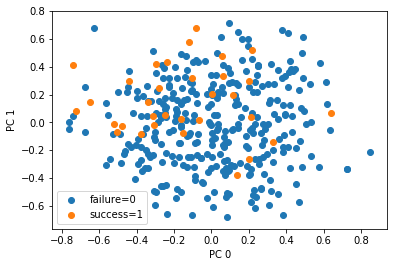

In [215]:
# Do PCA before and after SMOTE to see effects
pca_2d_before = PCA(n_components=2)
pca_2d_before.fit(X_train)
Z_train_pca_2d_before = pca_2d_before.transform(X_train)

print(Z_train_pca_2d_before.shape)
print(y_train.shape)
print(type(Z_train_pca_2d_before), type(y_train))

mask0 = (y_train == 0).values.ravel()
mask1 = (y_train == 1).values.ravel()

fig, ax = plt.subplots()

# ax.scatter(Z[:, 0], Z[:, 1]) # Z[:, 0] - first col, Z[:, 1], 2nd col

# numpy slicing arr[row, col]
ax.scatter(Z_train_pca_2d_before[mask0, 0], Z_train_pca_2d_before[mask0, 1], label='failure=0')
ax.scatter(Z_train_pca_2d_before[mask1, 0], Z_train_pca_2d_before[mask1, 1], label='success=1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.legend()
plt.show()

In [216]:
#address training set imbalance using smote
from imblearn.over_sampling import SMOTE
import imblearn

sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(type(X_train), type(y_train))

(656, 18) (656,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


C:\Users\Justin\Anaconda3\envs\mldds\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [217]:
y_train.sum()
#328 is 50% of 656. 

328

In [218]:
#create test sets
X_test = df_test.loc[:, features]
y_test=df_test.loc[:, target]

## Section 4: Feature Engineering

* Use PCA and calcualte Explained Variance Ratio to see if Feature Reduction is possible.
* PCA plot in 2D

before:  (656, 18)
after:  (656, 18)
Show Explained Variance:  [0.13567661 0.11707431 0.10786515 0.10295738 0.08711727 0.08589826
 0.07453784 0.07045516 0.06355851 0.05957474 0.05750653 0.05630857
 0.05484272 0.05449357 0.05299614 0.05014609 0.04776584 0.0471162 ]
Show Explained Variance Ratio:  [0.10232864 0.0882986  0.08135296 0.07765147 0.06570471 0.06478531
 0.05621717 0.05313798 0.04793645 0.04493185 0.043372   0.04246848
 0.04136292 0.04109959 0.03997021 0.03782068 0.03602547 0.03553551]


Text(0, 0.5, 'Total explained variance')

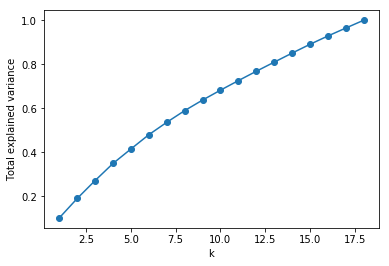

In [219]:
# Do PCA on X_train
pca = PCA()
pca.fit(X_train)
Z_train_pca = pca.transform(X_train)

print("before: ", X_train.shape)
print("after: ", Z_train_pca.shape)

print("Show Explained Variance: ", pca.explained_variance_)
print("Show Explained Variance Ratio: ", pca.explained_variance_ratio_)

fig, ax = plt.subplots()
ax.plot(np.arange(1, pca.explained_variance_ratio_.shape[0] + 1),
        pca.explained_variance_ratio_.cumsum(), marker='o')
ax.set_xlabel('k')
ax.set_ylabel('Total explained variance')

(656, 2)
(656,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


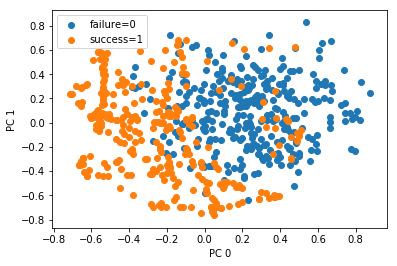

In [220]:
#PCA plot in 2D
pca_after = PCA(n_components=2)
pca_after.fit(X_train)
Z_train_pca_2d = pca_after.transform(X_train)
print(Z_train_pca_2d.shape)
print(y_train.shape)
print(type(Z_train_pca_2d), type(y_train))
mask0 = (y_train == 0)
mask1 = (y_train == 1)

fig, ax = plt.subplots()

# ax.scatter(Z[:, 0], Z[:, 1]) # Z[:, 0] - first col, Z[:, 1], 2nd col

# numpy slicing arr[row, col]
ax.scatter(Z_train_pca_2d[mask0, 0], Z_train_pca_2d[mask0, 1], label='failure=0')
ax.scatter(Z_train_pca_2d[mask1, 0], Z_train_pca_2d[mask1, 1], label='success=1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.legend()
plt.show()

### PCA Observation
From the plot of 'Total Explained Variance', we observe a near straight line.
This indicates that most of the variance cannot be explained by a few linear combinations of the columns. 
This observation further verifies that the use of Latin Hypercube method.

In plotting the first 2 eigenvectors from the PCA, we observe some separation (ie. bottom left vs top right.)  

## Section 5: Model Engineering

We use the following models:
* SVM (radial basis function)
* KBest + SVM (radial basis function)
* Bagging with SVM (linear function)

The data has been previously split to train and test based on 'Study' column.
Training set was obtained for 'Study' == 1 or 2. This consists of 360 rows, and using SMOTE, increased to 656.

Given the relatively small amount of data (656 rows) and multi-dimensionality (18) of the data, we use SVM (ie. radial-basis function).

### Model: SVM

In [221]:
#Create Pipeline
pipeline_svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

cv_svm = cross_validate(pipeline_svm, X_train, y_train, cv=3, return_estimator=True, return_train_score=True)
cv_svm['test_score']

array([0.99090909, 0.97706422, 0.97247706])

In [222]:
# highest validation score
model_svm = cv_svm['estimator'][0]

### Model: KBest + SVM

#### Add SelectKBest
First, we determine the number of features to use in KBest.

Then, add to pipeline to re-run SVM

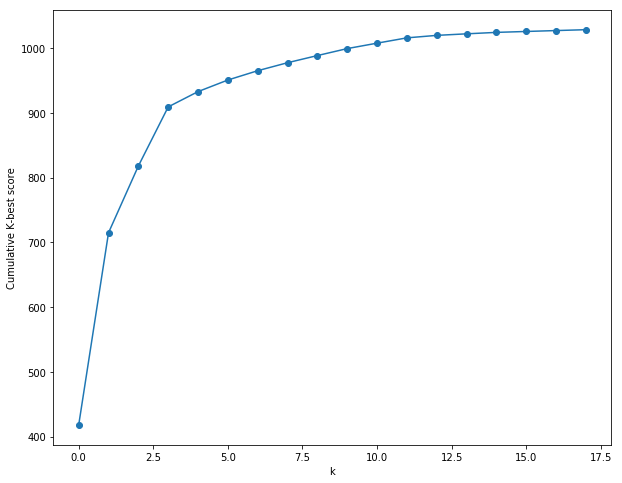

In [223]:
from sklearn.feature_selection import SelectKBest, f_classif
kbest = SelectKBest(f_classif, k=18)
X_kbest = kbest.fit_transform(X_train, y_train)
#kbest_cols = X.columns[kbest.get_support()]
fig, ax = plt.subplots(figsize=(10, 8))

# sort kbest scores in descending order
kbest_sorted = np.array(sorted(kbest.scores_, reverse=True))

# plot the cumulative sum (sum of scores vs. k)
ax.plot(kbest_sorted.cumsum(), marker='o')

ax.set_xlabel('k')
ax.set_ylabel('Cumulative K-best score')

plt.show()

From the plot, k=4 is the elbow point.

In [224]:
#show the 4 best columns
kbest4 = SelectKBest(f_classif, k=4)
X_kbest4 = kbest4.fit_transform(X_train, y_train)
df_train_features=df_train[['vconst_corr', 'vconst_2', 'vconst_3', 'vconst_4',
       'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus', 'slm_corr',
       'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq',
       'bckgrnd_vdc_psim', 'Prandtl']]
df_train_features.columns[kbest4.get_support()]
#print zip(fs.get_support(),features_columns)

Index(['vconst_corr', 'vconst_2', 'convect_corr', 'bckgrnd_vdc1'], dtype='object')

The 4 best features are the ones earlier identified the the pairplots. 

In [225]:
# incorporate into new pipeline.
pipeline_svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(k=4)),
    ('svm', SVC(kernel='rbf'))
])

cv_kbest_svm = cross_validate(pipeline_svm, X_train, y_train, cv=3, return_estimator=True, return_train_score=True)
cv_kbest_svm['test_score']

array([0.97272727, 0.94954128, 0.94954128])

In [226]:
model_kbest_svm = cv_kbest_svm['estimator'][0]

### Model: Bagging with SVM

In [227]:
from sklearn.ensemble import BaggingClassifier

pipeline_bagging_svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', BaggingClassifier(base_estimator=SVC(kernel='rbf'), n_estimators=5))
])

cv_bagging_svm = cross_validate(pipeline_bagging_svm, X_train, y_train, cv=3, return_estimator=True, return_train_score=True)
cv_bagging_svm['test_score']

array([0.99090909, 0.97247706, 0.98165138])

In [228]:
model_bagging_svm = cv_bagging_svm['estimator'][0]

## Section 6: Evaluate Metrics

We evaluate the onfusion matrix and AUC of:
* SVM
* KBest+SVM
* Bagging with SVM

### Evaluate SVM

In [229]:
# Get predictions
y_pred_svm = model_svm.predict(X_test)

# Get confusion matrix
print(confusion_matrix(y_test, y_pred_svm))

[[161   5]
 [  6   8]]


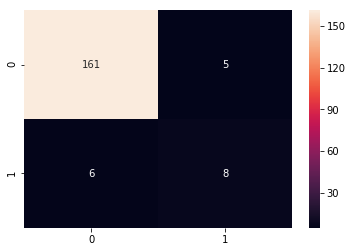

In [230]:
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d')
plt.show()

In [231]:
# Precision / Recall
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       166
           1       0.62      0.57      0.59        14

   micro avg       0.94      0.94      0.94       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.94      0.94      0.94       180



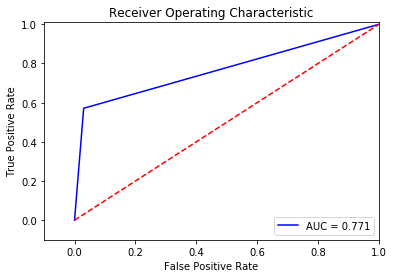

In [232]:
#do ROC plot
y_pred_sample_score = model_svm.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Evaluate KBest + SVM

In [233]:
# Get predictions
y_pred_kbest_svm = model_kbest_svm.predict(X_test)

# Get confusion matrix
print(confusion_matrix(y_test, y_pred_kbest_svm))

[[157   9]
 [  2  12]]


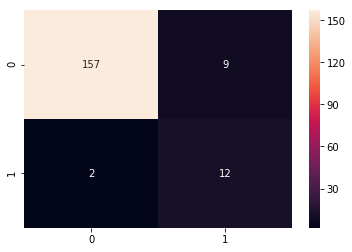

In [234]:
sns.heatmap(confusion_matrix(y_test, y_pred_kbest_svm), annot=True, fmt='d')
plt.show()

In [235]:
# Precision / Recall
print(classification_report(y_test, y_pred_kbest_svm))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       166
           1       0.57      0.86      0.69        14

   micro avg       0.94      0.94      0.94       180
   macro avg       0.78      0.90      0.83       180
weighted avg       0.96      0.94      0.94       180



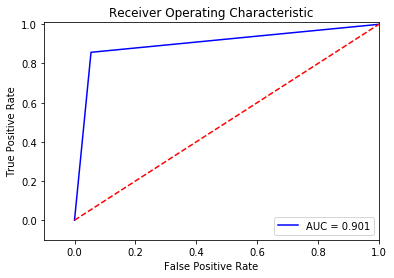

In [236]:
#do ROC plot
y_pred_sample_score = model_svm.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_kbest_svm)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Evaluate Bagging with SVM

In [237]:
# Get predictions
y_pred_bagging_svm = model_bagging_svm.predict(X_test)

# Get confusion matrix
print(confusion_matrix(y_test, y_pred_bagging_svm))

[[159   7]
 [  5   9]]


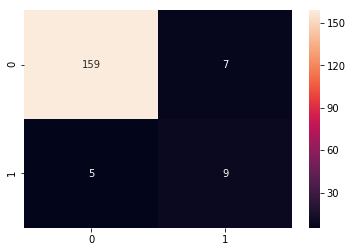

In [238]:
sns.heatmap(confusion_matrix(y_test, y_pred_bagging_svm), annot=True, fmt='d')
plt.show()

In [239]:
# Precision / Recall
print(classification_report(y_test, y_pred_bagging_svm))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       166
           1       0.56      0.64      0.60        14

   micro avg       0.93      0.93      0.93       180
   macro avg       0.77      0.80      0.78       180
weighted avg       0.94      0.93      0.94       180



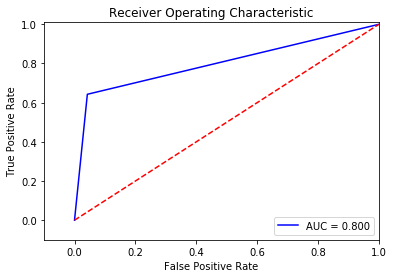

In [240]:
#do ROC plot
y_pred_sample_score = model_svm.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_bagging_svm)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Section 7: Observations and analysis

Answer the following questions:
1. What do you conclude from the metrics?

2. If the metrics are not good, try to find out what is the reason in order to improve the model. What kind of inputs does the model not do well? (i.e. what are the blind spots or invalid assumptions?). Note that to answer this question, you need to decide what a "good" result is for your problem formulation.

3. What improvements do you propose?

In comparing the "SVM", "KBest+SVM" and "Bagging with SVM", we observe from the confusion matrix that all models misclassified 11 cases 
(ie not necessarily the same cases), which resulted in the same weighted F1 score.

"KBest+SVM" is a more parsimonious model, where kbest identified the 'best' 4 features (which have been earlier identified in the pairplot). 
These were also mentioned in the reference paper. 
It also had the best ROC curve amongst the models (ie. largest AUC), which points to a better trade of between true positive and false positive rate.

We note that Precision, Recall and F1 score are more appropriate measures for imbalanced datasets, and that ROC is a better metric for balanced data sets.
